## What is a graph?

A graph, in the mathematical sense, is a collection of nodes and edges. Sometimes nodes are called vertices, and sometimes graphs are called networks, but it's all the same thing. The mathematical notation for a graph is usually:

$$ G = (N,E) $$

Which simple says that a graph $G$ comprises a set of nodes $N$ and edges $E$ connecting nodes. In this workshop, we're only going to consider *undirected graphs*, which treats a connection between two nodes $N_{i}$ and $N_{j}$ as  linking the two nodes in both directions.

Our lab has developed a toolkit for analyzing graphs called [`graphtools`](https://github.com/KrishnaswamyLab/graphtools), and some of the backend is provided by the excellent [`pygsp`](https://github.com/epfl-lts2/pygsp) toolkit. 

#### Creating some random data

In [38]:
import pygsp
import matplotlib.pyplot as plt
import numpy as np

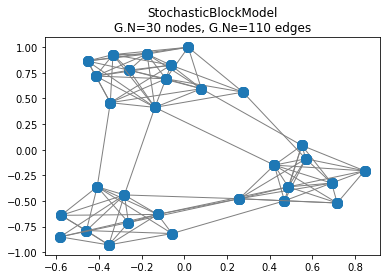

In [67]:
# Use pygsp to create a random graph
G = pygsp.graphs.stochasticblockmodel.StochasticBlockModel(30, k=3, p=0.7, q=0.05)

# Generate 2D coordinates using "spring" aka
# "force directed layout"
G.set_coordinates('spring')

# create the plot using pygsp's helper function
G.plot()

#### Interpreting the plot

The graph above is a generating using a generative model called the Stochastic Block Model. This is actually a very simple way to create a random graph. Nodes are created in sets of clusters. There is some probability $p$ that nodes within a cluster will share an edge, and some probability $q$ that nodes in different clusters will share an edge.

The important takeaway here is that such a graph is made up of only two kinds of things, nodes and edges, yet we can easily imagine this graph represents important relationships in a dataset.

This graph could represent:  
* Friendships in a social network  
* Protein-protein interactions
* Gene regulatory interactions

Moving forward, we're going to use graphs to model similarity between high-dimensional data points. We're starting with this community model because it's hopefully more familiar and it demonstrates the broad applicability of graphs to model data.

### Why use a graph to model relationships between data points?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'size'   : 16}
mpl.rc('font', **font)

import seaborn as sns

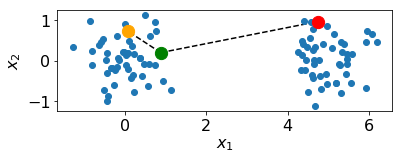

In [12]:
# Set random seed to ensure same results across runs
np.random.seed(0)

# Create a Gaussian ball centered at (0,0)
ball_left = np.random.normal(0, 0.5, size=(50,2))

# Create a Gaussian ball centered at (5,0)
ball_right = np.random.normal([5,0], 0.5, size=(50,2))

# Join the data into a single array of shape [125,2]
data = np.vstack([ball_left, ball_right])

# Pick the three pts we're concerned about
green_pt = 0
orange_pt = 5
red_pt = 80

# Plot the data
fig, ax = plt.subplots(1)

ax.scatter(data[:,0], data[:,1])
ax.scatter(data[green_pt,0], data[green_pt,1], color='green', s=150)
ax.scatter(data[orange_pt,0], data[orange_pt,1], color='orange', s=150)
ax.scatter(data[red_pt,0], data[red_pt,1], color='red', s=150)

# Plot lines
ax.plot(data[[green_pt,orange_pt],0], data[[green_pt,orange_pt],1], linestyle='--',color='k', zorder=0)
ax.plot(data[[green_pt,red_pt],0], data[[green_pt,red_pt],1],       linestyle='--',color='k', zorder=0)



# Decorate the axes
ax.set_aspect(1)
ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')
#ax.set_title('How can we quantify "close" vs. "far"?'); # closing semi-colon prevents printing the text 
fig.savefig('../img/glocal.two_clusters.basic.png', dpi=300)

In [6]:
data[[green_point,orange_point],0]

array([0.88202617, 0.07202179])

Here we've got 100 points total, but let's focus on three: the orange, green, and red points. Intuitively, we can see that the green and orange points are "close" and the red point is "far". How can we quantify this?

One apporach would be to take some number of neighbors, let's call it $k$,  and calculate the Euclidean distance to the $k$th neighbor.

Algorithmically, one does this by first calculating all pairwise distances between points, and then sorting the distances in each row.

We can calculate pairwise distances using a function called `scipy.spatial.distance.pdist()`.

In [129]:
from scipy.spatial.distance import pdist, squareform

# pdist only returns unique pariwise distances to save memory
# remember dist(a,b) = dist(b,a))
# squareform converts this to a matrix that we can visualize
pairwise_distances = squareform(pdist(data))

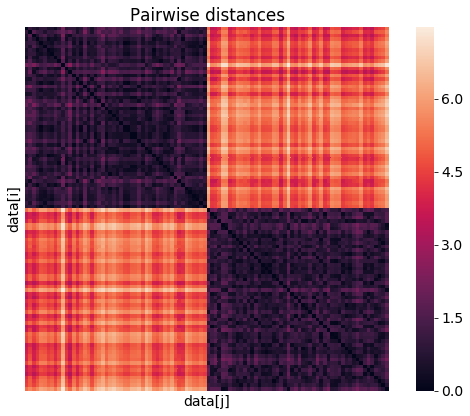

In [11]:
# Seaborn has a nice heatmap function
ax = sns.heatmap(pairwise_distances)

# Plot decorations
ax.set_title('Pairwise distances')
ax.set_xlabel('data[j]'); ax.set_ylabel('data[i]')
ax.set_xticks([]); ax.set_yticks([]);
ax.set_aspect(1)

fig = ax.figure
fig.set_size_inches(8,6)
fig.tight_layout()

#### Interpreting the heatmap

In the above plot, we can see all of the pairwise distance between cells. Each square in the heatmap is distance between those two points. Note that the diagonal line is all 0. We also notice a distinct block-like structure in the diagram. The dark purple blocks indicate small distances between points within the left cluster (upper left) and between points within the right cluster (lower right). The upper right and lower left halves are orange and indicate relatively larger distances between the left and right clusters.

Here you can already generate an idea of what a "close" vs "far" distance is. Close is purple and far is orange! Let's continue to look at the relative distances for the orange to green and orange to red points



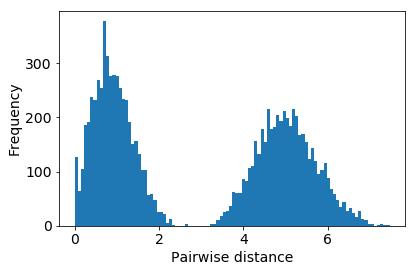

In [12]:
fig, ax = plt.subplots(1, figsize=(6,4))

# This creates the histogram
ax.hist(pairwise_distances.flatten(), bins=100)

# Plot decorations
ax.set_xlabel('Pairwise distance')
ax.set_ylabel('Frequency')

fig.tight_layout()

#### Interpreting the histogram

In the above plot, we can see the frequency of each of the pairwise distance between cells. This plot is strikingly bimodal, and this makes sense for the data. We generally expect the distances within a cluster to be small and distances between clusters to be large. This corresponds to the left and right peak respectively.

Here you can already generate an idea of what a "close" vs "far" distance is. Let's continue to look at the relative distances for the orange to green and orange to red points.

#### Calculating the k-NearestNeighbor

In [13]:
# Here, we're going to do something a little complicated.
# First, we're going to get the indicdes that would 
# sort the distance matrix using `np.argsort()`.

# For example, if `a = np.array([4,2,6])`
# np.argsort(a) -> [1,2,0]
sort_indices = np.argsort(pairwise_distances,  axis=1 )

# Find the kth neighbor
k = 5
# Why do we add 1 to k here?
knn = sort_indices[:,:k+1]

#### Plotting k-NN relationships

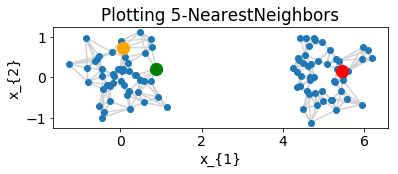

In [15]:
# Plot the data
fig, ax = plt.subplots(1)

ax.scatter(data[:,0], data[:,1])
ax.scatter(data[green_point,0],  data[green_point,1], color='green', s=150)
ax.scatter(data[orange_point,0], data[orange_point,1], color='orange', s=150)
ax.scatter(data[red_point,0],    data[red_point,1], color='red', s=150)

# This block of code draws lines between each point and its k-nearest neighbors
for i, pt in enumerate(data):
    neighbors = knn[i]
    for nn in neighbors:
        nn_coordinates = data[nn]
        ax.plot([pt[0], nn_coordinates[0]], [pt[1], nn_coordinates[1]],
               color='lightgrey', zorder=0)


# Decorate the axes
ax.set_aspect(1)
ax.set_xlabel('x_{1}')
ax.set_ylabel('x_{2}')
ax.set_title('Plotting {}-NearestNeighbors'.format(k)); 

#### Interpreting the k-NN plot

The reason we plotted these relationships to illustrate an important point. **None of the lines connect the two clusters.** This is important for reasons that will become more clear later. For now, what important is that we don't ever observe data between these two clusters. See for yourself, how large can you make `k` before lines start connecting the clusters?



In [71]:
import sklearn.datasets

In [126]:
x = np.random.uniform(-1,1, 100)

y = (2*x) ** 2
x += np.random.normal(0,.1, 100)

data = np.vstack([x,y]).T

In [124]:
import scprep

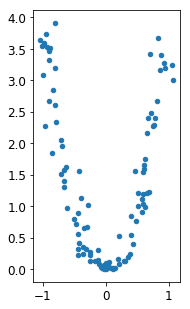

In [127]:
fig, ax = plt.subplots(1, figsize=(5,5))

scprep.plot.scatter2d(data, ax=ax)
ax.set_aspect(1)

In [132]:
pairwise_distances = squareform(pdist(data))

In [137]:
# Here, we're going to do something a little complicated.
# First, we're going to get the indicdes that would 
# sort the distance matrix using `np.argsort()`.

# For example, if `a = np.array([4,2,6])`
# np.argsort(a) -> [1,2,0]
sort_indices = np.argsort(pairwise_distances,  axis=1 )

# Find the kth neighbor
k = 5
# Why do we add 1 to k here?
knn = sort_indices[:,:k+1]

#### Plotting k-NN relationships

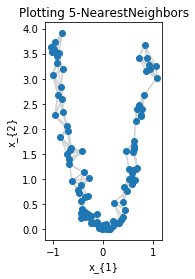

In [138]:
# Plot the data
fig, ax = plt.subplots(1)

ax.scatter(data[:,0], data[:,1])

# This block of code draws lines between each point and its k-nearest neighbors
for i, pt in enumerate(data):
    neighbors = knn[i]
    for nn in neighbors:
        nn_coordinates = data[nn]
        ax.plot([pt[0], nn_coordinates[0]], [pt[1], nn_coordinates[1]],
               color='lightgrey', zorder=0)

# Decorate the axes
ax.set_aspect(1)
ax.set_xlabel('x_{1}')
ax.set_ylabel('x_{2}')
ax.set_title('Plotting {}-NearestNeighbors'.format(k)); 

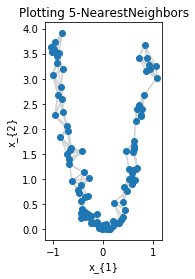

In [138]:
# Plot the data
fig, ax = plt.subplots(1)

ax.scatter(data[:,0], data[:,1])

# This block of code draws lines between each point and its k-nearest neighbors
for i, pt in enumerate(data):
    neighbors = knn[i]
    for nn in neighbors:
        nn_coordinates = data[nn]
        ax.plot([pt[0], nn_coordinates[0]], [pt[1], nn_coordinates[1]],
               color='lightgrey', zorder=0)

# Decorate the axes
ax.set_aspect(1)
ax.set_xlabel('x_{1}')
ax.set_ylabel('x_{2}')
ax.set_title('Plotting {}-NearestNeighbors'.format(k)); 

In [79]:
data, t = sklearn.datasets.make_swiss_roll()

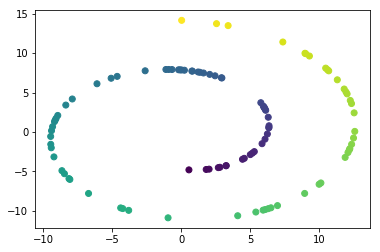

In [83]:
plt.scatter(data[:,0], data[:,2], c=t)